In [ ]:

############## Vector Stores ################
import uuid
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain.schema.document import Document
from langchain.embeddings import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever


############## Summaries ####################
import openai
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain.chains import LLMChain
from langchain_openai import ChatOpenAI
from langchain.chat_models import init_chat_model
from langchain_openai import OpenAI


############ RAG PIPELINE ###########
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import SystemMessage, HumanMessage
from base64 import b64decode


######### PODCAST ############
from podcastfy.client import generate_podcast



###### AUDIO DISPLAY ##############
from IPython.display import Audio, display


############ Keys ##########
from dotenv import load_dotenv
load_dotenv()

True

# Stage 1 : Partition PDF

In [3]:
from unstructured.partition.pdf import partition_pdf
pdf_path = "./data/pdfs/"
file_path = pdf_path + "attention.pdf"

# Reference: https://docs.unstructured.io/open-source/core-functionality/chunking
chunks = partition_pdf(
    filename=file_path,
    infer_table_structure=True,            # extract tables
    strategy="hi_res",                     # mandatory to infer tables

    extract_image_block_types=["Image"],   # Add 'Table' to list to extract image of tables
    # image_output_dir_path=output_path,   # if None, images and tables will saved in base64

    extract_image_block_to_payload=True,   # if true, will extract base64 for API usage

    chunking_strategy="by_title",          # or 'basic'
    max_characters=10000,                  # defaults to 500
    combine_text_under_n_chars=2000,       # defaults to 0
    new_after_n_chars=6000,

    # extract_images_in_pdf=True,          # deprecated
)

/opt/miniconda3/envs/multimodal-rag-podcast/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Stage 2 : Extracting Text, Tables and Images from : Partition PDF

# Texts

In [4]:
# Get the images from the CompositeElement object
texts=chunks
print(texts[0])

3

2023

2

0

2

g u A 2 ] L C . s c [ 7 v 2 6 7 3 0 . 6 0

7

1

:

v

arXiv

i

X

r

a

Provided proper attribution is provided, Google hereby grants permission to reproduce the tables and figures in this paper solely for use in journalistic or scholarly works.

Attention Is All You Need

Ashish Vaswani∗

Google Brain

avaswani@google.com

Noam Shazeer∗ Google Brain noam@google.com

Niki Parmar∗ Google Research nikip@google.com

Jakob Uszkoreit∗

Google Research usz@google.com

Llion Jones∗

Google Research llion@google.com

Aidan N. Gomez∗ † University of Toronto aidan@cs.toronto.edu

Łukasz Kaiser∗ Google Brain lukaszkaiser@google.com

Illia Polosukhin∗ ‡

illia.polosukhin@gmail.com

Abstract

The dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a decoder. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the 

In [5]:
texts[5].metadata.orig_elements

In [6]:
[i for i in texts[5].metadata.orig_elements if 'Table' in str(type(i))]

# Tables

In [7]:
# Get the images from the CompositeElement objects
def get_tables(chunks):
    tables_dict = {}
    tables_html_dict={}
    count=0
    for chunk in chunks: 
        elements = chunk.metadata.orig_elements
        for el in elements:
            if 'Table' in str(type(el)):
                chunk_tables = [el for el in elements if 'Table' in str(type(el))]
                chunk_tables_html = [el.metadata.text_as_html for el in elements if 'Table' in str(type(el))]
                tables_dict[count] = chunk_tables
                tables_html_dict[count] = chunk_tables_html
        count+=1
            
    return tables_dict, tables_html_dict


tables, tables_html = get_tables(chunks)

In [8]:
tables_html

{5: ['<table><thead><tr><th>Layer Type</th><th>Complexity per Layer</th><th>Sequential Operations</th><th>Maximum Path Length</th></tr></thead><tbody><tr><td>Self-Attention</td><td>O(n? - d)</td><td>O(1)</td><td>O(1)</td></tr><tr><td>Recurrent</td><td>O(n- d?)</td><td>O(n)</td><td>O(n)</td></tr><tr><td>Convolutional</td><td>O(k-n-d?)</td><td>O(1)</td><td>O(logy(n))</td></tr><tr><td>Self-Attention (restricted)</td><td>O(r-n-d)</td><td>ol)</td><td>O(n/r)</td></tr></tbody></table>'],
 7: ['<table><thead><tr><th>Model</th><th>EN-DE</th><th>BLEU EN-FR</th><th>Training EN-DE</th><th>Cost (FLOPs) EN-FR</th></tr></thead><tbody><tr><td colspan="5">ByteNet [18] 23.75</td></tr><tr><td>Deep-Att + PosUnk</td><td></td><td>39.2</td><td></td><td>1.0 - 107°</td></tr><tr><td>GNMT + RL 8]</td><td>24.6</td><td>39.92</td><td>2.3-10!9</td><td>1.4-1070</td></tr><tr><td>ConvS28S [9]</td><td>25.16</td><td>40.46</td><td>9.6-10\'%</td><td>1.5-1070</td></tr><tr><td>MoE</td><td>26.03</td><td>40.56</td><td>2.0-10\'

# Images

In [9]:
# Get the images from the CompositeElement objects
def get_images_base64(chunks):
    images_b64 = []
    for chunk in chunks:
        chunk_els = chunk.metadata.orig_elements
        for el in chunk_els:
            if "Image" in str(type(el)):
                images_b64.append(el.metadata.image_base64)
    return images_b64

images = get_images_base64(chunks)

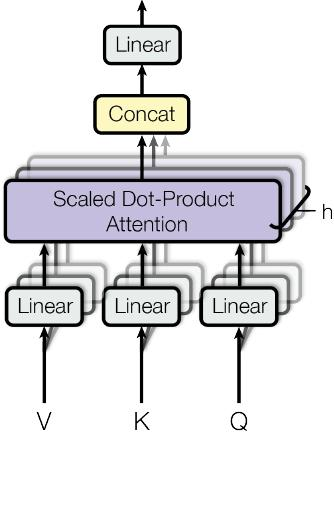

In [10]:
import base64
from IPython.display import Image, display

def display_base64_image(base64_code):
    # Decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    # Display the image
    display(Image(data=image_data))

display_base64_image(images[2])

# Stage 3a :Summarizing Tables and Text per Chunk

In [16]:
# Prompt
prompt_text = """
You are an assistant tasked with summarizing tables and text.
Give a concise summary of the table or text.

Respond only with the summary, no additional comment.
Do not start your message by saying "Here is a summary" or anything like that.
Just give the summary as it is.

Table or text chunk: {element}

"""
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
model = ChatOpenAI(model="gpt-4o-mini")
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

In [17]:
text_summaries = summarize_chain.batch(texts, {"max_concurrency" : 3})
table_summaries = summarize_chain.batch(tables_html.values(), {"max_concurrency" : 3})

In [18]:
table_summaries

['The table compares different layer types in terms of complexity per layer, sequential operations, and maximum path length. Self-Attention has complexity O(n? - d), with sequential operations and path length both O(1). Recurrent layers have a complexity of O(n - d?), with O(n) for sequential operations and O(n) for path length. Convolutional layers show complexity O(k-n-d?), with O(1) operations and a path length of O(logy(n)). Restricted Self-Attention has a complexity of O(r-n-d), operations denoted as "ol", and a maximum path length of O(n/r).',
 'The table compares various translation models based on their performance in English to German (EN-DE) and English to French (EN-FR) translations, along with training requirements and computational cost (measured in FLOPs). Key models include ByteNet, GNMT, and Transformer, with EN-DE BLEU scores ranging from 23.75 to 28.4 and EN-FR scores from 38.1 to 41.8. Models such as MoE and ensembles of Deep-Att and GNMT show improved performance, w

In [19]:
text_summaries

["The paper introduces the Transformer, a new architecture for sequence transduction tasks that relies entirely on attention mechanisms, eliminating the need for recurrence and convolutions. The Transformer outperforms existing complex models in machine translation, achieving a BLEU score of 28.4 for English-to-German and 41.8 for English-to-French, while requiring less training time. The architecture also demonstrates strong generalization capabilities beyond translation tasks. The authors, associated with Google Brain and Google Research, contributed to various aspects of the model's development and evaluation.",
 'Recurrent neural networks, particularly long short-term memory and gated recurrent networks, have been key in sequence modeling tasks like language modeling and machine translation. However, their sequential nature limits parallelization and efficiency, especially with longer sequences. Attention mechanisms have improved dependency modeling across sequences, yet they are o

# Stage 3b: Summarizing Images per Chunk

In [20]:


prompt_template = """Describe the image in detail. For context,
                  the image is part of a research paper explaining the transformers
                  architecture. Be specific about graphs, such as bar plots."""
messages = [
    (
        "user",
        [
            {"type": "text", "text": prompt_template},
            {
                "type": "image_url",
                "image_url": {"url": "data:image/jpeg;base64,{image}"},
            },
        ],
    )
]

prompt = ChatPromptTemplate.from_messages(messages)

chain = prompt | ChatOpenAI(model="gpt-4o-mini") | StrOutputParser()


image_summaries = chain.batch(images)

In [21]:
chain

ChatPromptTemplate(input_variables=['image'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=[PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='Describe the image in detail. For context,\n                  the image is part of a research paper explaining the transformers\n                  architecture. Be specific about graphs, such as bar plots.'), ImagePromptTemplate(input_variables=['image'], input_types={}, partial_variables={}, template={'url': 'data:image/jpeg;base64,{image}'})], additional_kwargs={})])
| ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x105f0b6e0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x31ca971a0>, root_client=<openai.OpenAI object at 0x31c9a1c40>, root_async_client=<openai.AsyncOpenAI object at 0x31ef3cdd0>, model_name='gpt-4o-mini', model_kwargs={}, openai_api_key=SecretStr('**********'))
| StrOutputParse

In [22]:
print(image_summaries[1])

The image depicts a flowchart or diagram that summarizes a process related to the transformer architecture. Here's a detailed description:

1. **Vertical Orientation**: The components are arranged in a vertical column, indicating a step-by-step flow of operations.

2. **Top Section**:
   - At the top, there is a block labeled "MatMul" in purple. This suggests that it is the final matrix multiplication step in the workflow.

3. **Middle Components**: 
   - Below the top "MatMul," there's a green box labeled "SoftMax," indicating the application of the softmax function, which is typically used to convert scores into probabilities.
   - Beneath that is a pink box labeled "Mask (opt.)," which suggests an optional masking step often used in attention mechanisms to handle padding or to prevent certain information from influencing others.
   - Below this, there is a yellow box labeled "Scale," which likely refers to scaling the attention scores by a factor, usually the square root of the dime

# Stage 4: Load the data and summaries to vector store

In [23]:
# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=OpenAIEmbeddings())

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

/var/folders/b6/2jpnyd7j0m9790zmwsq_bvdw0000gn/T/ipykernel_56354/3922053165.py:2: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=OpenAIEmbeddings())
/var/folders/b6/2jpnyd7j0m9790zmwsq_bvdw0000gn/T/ipykernel_56354/3922053165.py:2: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(collection_name="mul

## Load the summaries and link to the original data

In [24]:
# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=summary, metadata={id_key: doc_ids[i]}) for i, summary in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

# Add tables
table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [
    Document(page_content=summary, metadata={id_key: table_ids[i]}) for i, summary in enumerate(table_summaries)
]
retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(table_ids, tables)))

# Add image summaries
img_ids = [str(uuid.uuid4()) for _ in images]
summary_img = [
    Document(page_content=summary, metadata={id_key: img_ids[i]}) for i, summary in enumerate(image_summaries)
]
retriever.vectorstore.add_documents(summary_img)
retriever.docstore.mset(list(zip(img_ids, images)))

In [25]:
retrieved_chunks = retriever.invoke("what is attention?")
retrieved_chunks

 '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAIlBDYDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigA

In [26]:
for doc in retrieved_chunks:
    print(str(doc) + "\n\n" + "-" * 80)

3.2 Attention

An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors. The output is computed as a weighted sum

3

Scaled Dot-Product Attention

Multi-Head Attention

Linear

Figure 2: (left) Scaled Dot-Product Attention. (right) Multi-Head Attention consists of several attention layers running in parallel.

of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.

3.2.1 Scaled Dot-Product Attention

We call our particular attention "Scaled Dot-Product Attention" (Figure 2). The input consists of queries and keys of dimension dk, and values of dimension dv. We compute the dot products of the √ dk, and apply a softmax function to obtain the weights on the query with all keys, divide each by values.

In practice, we compute the attention function on a set of queries simultaneously, packed together into a ma

In [ ]:


def parse_docs(docs):
    """Split base64-encoded images and texts"""
    b64 = []
    text = []
    for doc in docs:
        try:
            b64decode(doc)
            b64.append(doc)
        except Exception as e:
            text.append(doc)
    return {"images": b64, "texts": text}


def build_prompt(kwargs):

    docs_by_type = kwargs["context"]
    user_question = kwargs["question"]

    context_text = ""
    if len(docs_by_type["texts"]) > 0:
        for text_element in docs_by_type["texts"]:
            context_text += text_element.text

    # construct prompt with context (including images)
    prompt_template = f"""
    Answer the question based only on the following context, which can include text, tables, and the below image.
    Context: {context_text}
    Question: {user_question}
    """

    prompt_content = [{"type": "text", "text": prompt_template}]

    if len(docs_by_type["images"]) > 0:
        for image in docs_by_type["images"]:
            prompt_content.append(
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image}"},
                }
            )

    return ChatPromptTemplate.from_messages(
        [
            HumanMessage(content=prompt_content),
        ]
    )


chain = (
    {
        "context": retriever | RunnableLambda(parse_docs),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(build_prompt)
    | ChatOpenAI(model="gpt-4o-mini")
    | StrOutputParser()
)

chain_with_sources = {
    "context": retriever | RunnableLambda(parse_docs),
    "question": RunnablePassthrough(),
} | RunnablePassthrough().assign(
    response=(
        RunnableLambda(build_prompt)
        | ChatOpenAI(model="gpt-4o-mini")
        | StrOutputParser()
    )
)

In [28]:
response = chain.invoke(
    "What is attention formula?"
)

print(response)

The attention formula is given by:

\[
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{Q K^T}{\sqrt{d_k}}\right) V
\]

Where:
- \( Q \) is the matrix of queries.
- \( K \) is the matrix of keys.
- \( V \) is the matrix of values.
- \( d_k \) is the dimension of the keys.


Response: The Transformer architecture is a neural network model designed primarily for sequence transduction tasks, utilizing a novel approach that relies entirely on attention mechanisms rather than recurrence or convolution. It consists of an encoder-decoder structure. 

### Key Components:
1. **Encoder**: 
   - Composed of a stack of identical layers.
   - Each layer has two main sub-layers:
     - Multi-head self-attention mechanism.
     - Position-wise fully connected feed-forward network.
   - It employs residual connections and layer normalization.

2. **Decoder**: 
   - Similar to the encoder but has an additional sub-layer for attending to the encoder's output.
   - Incorporates masking to ensure that predictions for a given position depend only on previous positions.

### Attention Mechanism:
- The attention mechanism operates through:
  - Computing queries (Q), keys (K), and values (V) from the input.
  - Using matrix multiplications to derive attention scores, applying a 

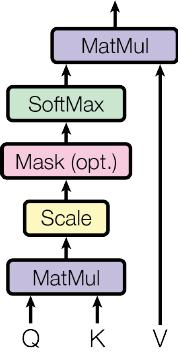

In [29]:
response = chain_with_sources.invoke(
    "What is the transformer architecture?"
)

print("Response:", response['response'])

print("\n\nContext:")
for text in response['context']['texts']:
    print(text.text)
    print("Page number: ", text.metadata.page_number)
    print("\n" + "-"*50 + "\n")
for image in response['context']['images']:
    display_base64_image(image)

# Podcast  with PDF
Create a Podcast of the PDF Summary with Specific Questions asked by RAG

### Prequsite Step 

 Include any specific question as questions from the auidence 

In [30]:
def specific_question_from_audience(l):
     
    response_outputs = ""

    for i in l:
        response = chain_with_sources.invoke(
            i
        )

        final_output_response = f"{response['response']} + "

        text = ""
        for r in response['context']['texts']:
            text = text + str(r)

        final_output_response = f"{response['response']}\n\nContext\n\n{text}" 

        response_outputs = response_outputs + f"Question:\n{i}\n\n" + f"Output from relevant chunks of the PDF:\n{final_output_response}"

    return response_outputs


In [32]:
specific_question_from_audience(["What is Positional Encoding", "What is Attention Mechanism Formula"])

'Question:\nWhat is Positional Encoding\n\nOutput from relevant chunks of the PDF:\n**Positional Encoding** in the context of the Transformer model is a technique used to provide information about the position of tokens in a sequence. Since the model does not rely on recurrence or convolution, it injects information regarding the relative or absolute position of the tokens by adding positional encodings to the input embeddings at the encoder and decoder stacks. These positional encodings are designed to maintain the same dimensionality as the input embeddings.\n\nThe specific method used for these encodings involves sine and cosine functions of varying frequencies, defined mathematically as:\n\n- \\( PE(pos, 2i) = \\sin\\left(\\frac{pos}{10000^{2i/d_{model}}}\\right) \\)\n- \\( PE(pos, 2i + 1) = \\cos\\left(\\frac{pos}{10000^{2i/d_{model}}}\\right) \\)\n\nwhere \\( pos \\) is the position and \\( i \\) is the dimension index. This methodological choice allows the model to learn relativ

### Step 1: Create a podcast_transcript

In [33]:
example_transcript = """Example Podcast Transcript: 
<Person1> "Hello listeners, and welcome to SID's Podcast - Your Personal Generative AI Podcast. Today, we're diving into a hot topic: Elon Musk and the fall of Tesla! Buckle up for a dynamic debate."
</Person1><Person2> "Absolutely! We're here to break down the factors behind Tesla's recent struggles and what role, if any, Elon Musk's decisions have played. Let's get into it!"
</Person2><Person1> "Right on! On one hand, there's a strong argument that attributes Tesla's challenges to Musk's controversial decisions and unpredictable public behavior. Critics suggest that these factors have shaken investor confidence and contributed to market volatility."
</Person1><Person2> "On the other hand, some say that Tesla's current hurdles are simply part of the natural business cycle—impacted by market competition, supply chain disruptions, and evolving consumer trends. They believe Musk's bold, innovative vision continues to drive the company forward."
</Person2><Person1> "Exactly. So the burning question is: Are Tesla's setbacks really the result of Musk's actions, or are they just a temporary phase in the journey of a pioneering tech company?"
</Person1><Person2> "Some point out that his high-profile social media antics and risky business maneuvers have created distractions, leading to an unstable market reaction. They argue that these issues highlight deeper problems in corporate governance."
</Person2><Person1> "Yet others counter that disruptive innovation is never a smooth ride. Musk's daring approach has propelled Tesla to unprecedented heights before, and current challenges might simply be a growing pain rather than a sign of irreversible decline."
</Person1><Person2> "Indeed. It really raises questions about leadership and accountability in high-stakes tech ventures. Can a visionary leader navigate such turbulence without compromising the company's mission?"
</Person2><Person1> "That's the million-dollar question. Whether you view it as a fall from grace or just a strategic pause, this discussion challenges us to reconsider the complex relationship between a leader's personality, corporate strategy, and market dynamics."
</Person1><Person2> "Well said! It's a multifaceted issue that goes beyond assigning blame, reminding us that in the world of disruptive technology, highs and lows are part of the journey."
</Person2><Person1> "Absolutely. That wraps up today's deep dive into Elon Musk and the challenges Tesla faces. Thanks for joining us on SID's Podcast. Until next time, stay curious and keep exploring!"
</Person1><Person2> "Catch you all on the next episode!"
</Person2>"""

text_summary = "Text Summaries:\n" + "\n".join(text_summaries)
table_summary = "Table Summaries:\n" + "\n".join(table_summaries)
image_summary = "Image Summaries:\n" + "\n".join(image_summaries)

In [34]:
template = """You are an assistant in TV channel tasked with creating a podcast transcript for two Hosts, hosting a podcast named SID's Podcast. Your task is to use Text Summaries, Table Summaries, Images Summaries and Specific Questions (From Audience) with context from a pdf to create a transcript similar to the given transcript (include html tags) in the output.

{text_summaries}

{table_summaries}

{image_summaries}

{specific_questions}

{example_transcript}

Add specific questions by audience at the end of the podcast in a QA session stating something like : 'Now lets us address the questions from our Audience' """

podcast_prompt_template = PromptTemplate(template=template, input_variables=["text_summaries", "table_summaries", "image_summaries", "specific_questions", "example_transcript"])
formatted_prompt = podcast_prompt_template.format(text_summaries=text_summary, 
                                 table_summaries=table_summary, 
                                 image_summaries=image_summary,
                                 specific_questions=specific_question_from_audience(["What is Positional Encoding", "What is Attention Mechanism Formula"]),
                                 example_transcript=example_transcript)

print(formatted_prompt)  # Output: Translate the following text to French: Hello, world!

You are an assistant in TV channel tasked with creating a podcast transcript for two Hosts, hosting a podcast named SID's Podcast. Your task is to use Text Summaries, Table Summaries, Images Summaries and Specific Questions (From Audience) with context from a pdf to create a transcript similar to the given transcript (include html tags) in the output.

Text Summaries:
The paper introduces the Transformer, a new architecture for sequence transduction tasks that relies entirely on attention mechanisms, eliminating the need for recurrence and convolutions. The Transformer outperforms existing complex models in machine translation, achieving a BLEU score of 28.4 for English-to-German and 41.8 for English-to-French, while requiring less training time. The architecture also demonstrates strong generalization capabilities beyond translation tasks. The authors, associated with Google Brain and Google Research, contributed to various aspects of the model's development and evaluation.
Recurrent 

In [41]:
model = init_chat_model("gpt-4o-mini", model_provider="openai")
response = model.invoke(formatted_prompt)

In [42]:
with open("data/transcripts/transcript.txt", "w") as file:
    file.write(response.content)

In [43]:
def embed_audio(audio_file):
	"""
	Embeds an audio file in the notebook, making it playable.

	Args:
		audio_file (str): Path to the audio file.
	"""
	try:
		display(Audio(audio_file))
		print(f"Audio player embedded for: {audio_file}")
	except Exception as e:
		print(f"Error embedding audio: {str(e)}")

In [47]:
audio_file = generate_podcast(transcript_file='data/transcripts/transcript.txt',
                              tts_model="edge",
                              llm_model_name="gpt-4o",
                              api_key_label="OPENAI_API_KEY")

2025-05-16 02:10:42,701 - podcastfy.client - INFO - Using transcript file: data/transcripts/transcript.txt


Generating podcast...


2025-05-16 02:11:00,416 - podcastfy.client - INFO - Podcast generated successfully using edge TTS model
